In [1]:
%matplotlib inline

In [2]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

In [3]:
IMG_DIM = (150, 150)

train_files = glob.glob('training_data\\*')
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [fn.split('\\')[1].split('.')[0].strip() for fn in train_files]

validation_files = glob.glob('validation_data\\*')
validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in validation_files]
validation_imgs = np.array(validation_imgs)
validation_labels = [fn.split('\\')[1].split('.')[0].strip() for fn in validation_files]

print('Train dataset shape:', train_imgs.shape, 
      '\tValidation dataset shape:', validation_imgs.shape)

Train dataset shape: (3000, 150, 150, 3) 	Validation dataset shape: (1000, 150, 150, 3)


In [4]:
train_imgs_scaled = train_imgs.astype('float32')
validation_imgs_scaled = validation_imgs.astype('float32')
train_imgs_scaled /= 255
validation_imgs_scaled /= 255

In [5]:
batch_size = 32
num_classes = 2
epochs = 30
input_shape = (150, 150, 3)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
# encode wine type labels
train_labels_enc = le.transform(train_labels)
validation_labels_enc = le.transform(validation_labels)

print(train_labels[0:5], train_labels_enc[0:5])

['cat', 'cat', 'cat', 'cat', 'cat'] [0 0 0 0 0]


In [6]:
from tensorflow.keras.applications import vgg16
from tensorflow.keras.models import Model
import tensorflow.keras

vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                                     input_shape=input_shape)

output = vgg.layers[-1].output
output = tensorflow.keras.layers.Flatten()(output)

vgg_model = Model(vgg.input, output)
vgg_model.trainable = False

for layer in vgg_model.layers:
    layer.trainable = False

vgg_model.summary()

58892288/58889256 [==============================] - 5s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_______________________________________________________

In [7]:
import pandas as pd
pd.set_option('max_colwidth', -1)

layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x00000170B3169308>,input_1,False
1,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000170B3243748>,block1_conv1,False
2,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000170B326D108>,block1_conv2,False
3,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x00000170B3404608>,block1_pool,False
4,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000170B3414788>,block2_conv1,False
5,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000170B3420C48>,block2_conv2,False
6,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x00000170B34210C8>,block2_pool,False
7,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000170B342BD48>,block3_conv1,False
8,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000170B3436908>,block3_conv2,False
9,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000170B3438CC8>,block3_conv3,False


In [8]:
print("Trainable layers:", vgg_model.trainable_weights)

Trainable layers: []


(1, 4, 4, 512)


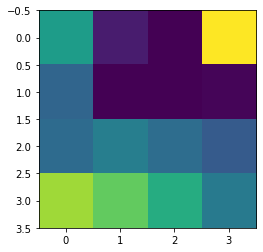

In [9]:
bottleneck_feature_example = vgg.predict(train_imgs_scaled[0:1])
print(bottleneck_feature_example.shape)
plt.imshow(bottleneck_feature_example[0][:,:,0])

In [10]:
def get_bottleneck_features(model, input_imgs):
    
    features = model.predict(input_imgs, verbose=0)
    return features

In [11]:
train_features_vgg = get_bottleneck_features(vgg_model, train_imgs_scaled)
validation_features_vgg = get_bottleneck_features(vgg_model, validation_imgs_scaled)

print('Train Bottleneck Features:', train_features_vgg.shape, 
      '\tValidation Bottleneck Features:', validation_features_vgg.shape)

Train Bottleneck Features: (3000, 8192) 	Validation Bottleneck Features: (1000, 8192)


In [12]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

input_shape = vgg_model.output_shape[1]

model = Sequential()
model.add(InputLayer(input_shape=(input_shape,)))
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               4194816   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 4,457,985
Trainable params: 4,457,985
Non-trainable params: 0
_________________________________________________________________


In [13]:
history = model.fit(x=train_features_vgg, y=train_labels_enc,
                    validation_data=(validation_features_vgg, validation_labels_enc),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

Epoch 1/30
94/94 [==============================] - 3s 33ms/step - loss: 0.4586 - accuracy: 0.7773 - val_loss: 0.3387 - val_accuracy: 0.8530
Epoch 2/30
94/94 [==============================] - 3s 32ms/step - loss: 0.3037 - accuracy: 0.8700 - val_loss: 0.2786 - val_accuracy: 0.8810
Epoch 3/30
94/94 [==============================] - 3s 32ms/step - loss: 0.2524 - accuracy: 0.8940 - val_loss: 0.2921 - val_accuracy: 0.8790
Epoch 4/30
94/94 [==============================] - 3s 32ms/step - loss: 0.2161 - accuracy: 0.9137 - val_loss: 0.2716 - val_accuracy: 0.8950
Epoch 5/30
94/94 [==============================] - 3s 32ms/step - loss: 0.1948 - accuracy: 0.9197 - val_loss: 0.2883 - val_accuracy: 0.8890
Epoch 6/30
94/94 [==============================] - 3s 32ms/step - loss: 0.1684 - accuracy: 0.9280 - val_loss: 0.2725 - val_accuracy: 0.8880
Epoch 7/30
94/94 [==============================] - 3s 32ms/step - loss: 0.1335 - accuracy: 0.9467 - val_loss: 0.2899 - val_accuracy: 0.8840
Epoch 8/30
94

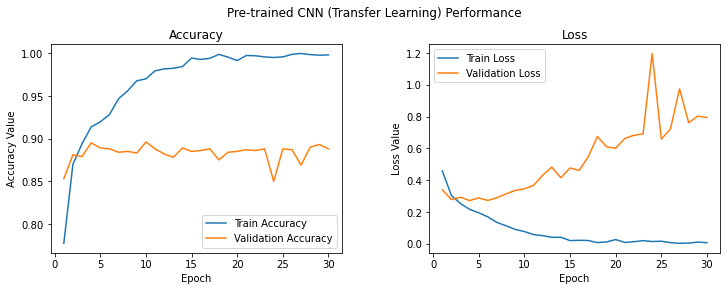

In [14]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Pre-trained CNN (Transfer Learning) Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,31))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 31, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 31, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [15]:
model.save('cats_dogs_tlearn_basic_cnn.h5')

In [16]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=30)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=20)

In [17]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

model = Sequential()
model.add(vgg_model)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_1 (Functional)    (None, 8192)              14714688  
_________________________________________________________________
dense_3 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 513       
Total params: 19,172,673
Trainable params: 4,457,985
Non-trainable params: 14,714,688
__________________________________

In [19]:
history = model.fit_generator(train_generator, steps_per_epoch=50, epochs=30,
                              validation_data=val_generator, validation_steps=50, verbose=1)  # steps_per_epoch=100, epochs=100,

Epoch 1/30
50/50 [==============================] - 263s 5s/step - loss: 0.5751 - accuracy: 0.7020 - val_loss: 0.4356 - val_accuracy: 0.8160
Epoch 2/30
50/50 [==============================] - 263s 5s/step - loss: 0.5323 - accuracy: 0.7440 - val_loss: 0.4024 - val_accuracy: 0.8330
Epoch 3/30
50/50 [==============================] - 268s 5s/step - loss: 0.5213 - accuracy: 0.7440 - val_loss: 0.3813 - val_accuracy: 0.8360
Epoch 4/30
50/50 [==============================] - 252s 5s/step - loss: 0.4999 - accuracy: 0.7487 - val_loss: 0.3629 - val_accuracy: 0.8510
Epoch 5/30
50/50 [==============================] - 251s 5s/step - loss: 0.4995 - accuracy: 0.7533 - val_loss: 0.3560 - val_accuracy: 0.8470
Epoch 6/30
50/50 [==============================] - 263s 5s/step - loss: 0.4728 - accuracy: 0.7767 - val_loss: 0.3437 - val_accuracy: 0.8530
Epoch 7/30
50/50 [==============================] - 281s 6s/step - loss: 0.4707 - accuracy: 0.7720 - val_loss: 0.3361 - val_accuracy: 0.8630
Epoch 8/30
50

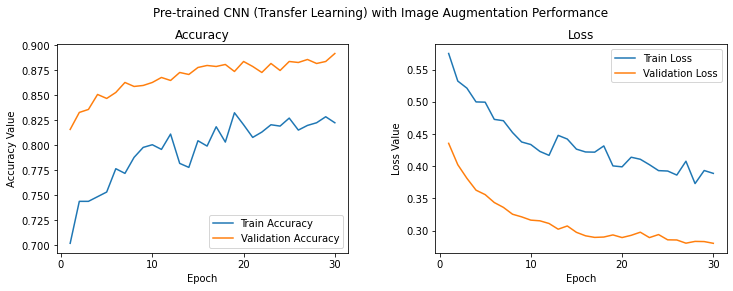

In [27]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Pre-trained CNN (Transfer Learning) with Image Augmentation Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,epochs+1))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epochs+1, 10))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epochs+1, 10))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [21]:
model.save('cats_dogs_tlearn_img_aug_cnn.h5')

In [22]:
vgg_model.trainable = True

set_trainable = False
for layer in vgg_model.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
print("Trainable layers:", vgg_model.trainable_weights)

Trainable layers: [<tf.Variable 'block4_conv1/kernel:0' shape=(3, 3, 256, 512) dtype=float32, numpy=
array([[[[-1.24538150e-02,  8.40655994e-03, -5.28845051e-03, ...,
          -2.04581907e-03, -3.92359449e-03,  1.30683812e-03],
         [ 1.15566896e-02,  2.46055960e-03, -4.09082584e-02, ...,
          -4.92062652e-03, -1.63423386e-03,  8.94230697e-03],
         [-1.43469922e-04, -5.65873180e-03,  1.84066985e-02, ...,
          -2.08840682e-03,  2.63321817e-06, -2.50728261e-02],
         ...,
         [ 1.37888230e-02, -6.58180192e-03,  9.65370331e-03, ...,
           7.17610447e-03,  3.45725450e-03,  5.33173978e-03],
         [ 2.65833316e-03,  7.77704641e-04,  2.86239345e-04, ...,
          -5.40583069e-03,  8.93119723e-03,  1.40043022e-02],
         [-8.53933115e-03,  1.43394794e-03, -2.91879033e-03, ...,
           3.77660524e-03,  2.05454584e-02, -1.35868033e-02]],

        [[-1.20176468e-02,  1.51250837e-03,  3.43130133e-03, ...,
          -1.57830697e-02, -2.39501009e-03,  2.93

In [23]:
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x00000170B3169308>,input_1,False
1,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000170B3243748>,block1_conv1,False
2,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000170B326D108>,block1_conv2,False
3,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x00000170B3404608>,block1_pool,False
4,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000170B3414788>,block2_conv1,False
5,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000170B3420C48>,block2_conv2,False
6,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x00000170B34210C8>,block2_pool,False
7,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000170B342BD48>,block3_conv1,False
8,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000170B3436908>,block3_conv2,False
9,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000170B3438CC8>,block3_conv3,False


In [24]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=32)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=20)

In [25]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

model = Sequential()
model.add(vgg_model)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_1 (Functional)    (None, 8192)              14714688  
_________________________________________________________________
dense_6 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 513       
Total params: 19,172,673
Trainable params: 17,437,185
Non-trainable params: 1,735,488
__________________________________

In [26]:
history = model.fit_generator(train_generator, steps_per_epoch=50, epochs=50,
                              validation_data=val_generator, validation_steps=50, verbose=1) # steps_per_epoch=100, epochs=100,

Epoch 1/50
50/50 [==============================] - 449s 9s/step - loss: 0.6620 - accuracy: 0.5886 - val_loss: 0.4748 - val_accuracy: 0.8300
Epoch 2/50
50/50 [==============================] - 444s 9s/step - loss: 0.5265 - accuracy: 0.7500 - val_loss: 0.3449 - val_accuracy: 0.8530
Epoch 3/50
50/50 [==============================] - 454s 9s/step - loss: 0.4343 - accuracy: 0.7906 - val_loss: 0.2656 - val_accuracy: 0.8900
Epoch 4/50
50/50 [==============================] - 433s 9s/step - loss: 0.3882 - accuracy: 0.8411 - val_loss: 0.2614 - val_accuracy: 0.8930
Epoch 5/50
50/50 [==============================] - 379s 8s/step - loss: 0.3820 - accuracy: 0.8367 - val_loss: 0.2451 - val_accuracy: 0.9050
Epoch 6/50
50/50 [==============================] - 267s 5s/step - loss: 0.3025 - accuracy: 0.8800 - val_loss: 0.1932 - val_accuracy: 0.9220
Epoch 7/50
50/50 [==============================] - 267s 5s/step - loss: 0.3166 - accuracy: 0.8681 - val_loss: 0.1920 - val_accuracy: 0.9150
Epoch 8/50
50

KeyboardInterrupt: 

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Pre-trained CNN (Transfer Learning) with Fine-Tuning & Image Augmentation Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,101))
ax1.plot(epoch_list, history.history['accaccuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accaccuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 101, 10))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 101, 10))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [ ]:
model.save('cats_dogs_tlearn_finetune_img_aug_cnn.h5')